<a href="https://colab.research.google.com/github/Shakilkhan24/Playground_DL/blob/main/image_captioning_practice_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# the code isn't obvious ,
just practicing image caption model finetuning using hugging face
and AutoProcessor for preprocessing images and captions
```



In [1]:
!pip install transformers datasets evaluate -q


In [2]:
!pip install jiwer

In [3]:
from datasets import load_dataset

ds = load_dataset("lambdalabs/pokemon-blip-captions")
print(ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})


In [4]:
print(ds['train'][0])   # an image and a caption associated with the image

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1280 at 0x7F90FEC9E320>, 'text': 'a drawing of a green pokemon with red eyes'}




```
# Splitting into train and test , as their is no test data specified
```



In [5]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

In [6]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'text'],
    num_rows: 749
})
Dataset({
    features: ['image', 'text'],
    num_rows: 84
})


Plotting the datas

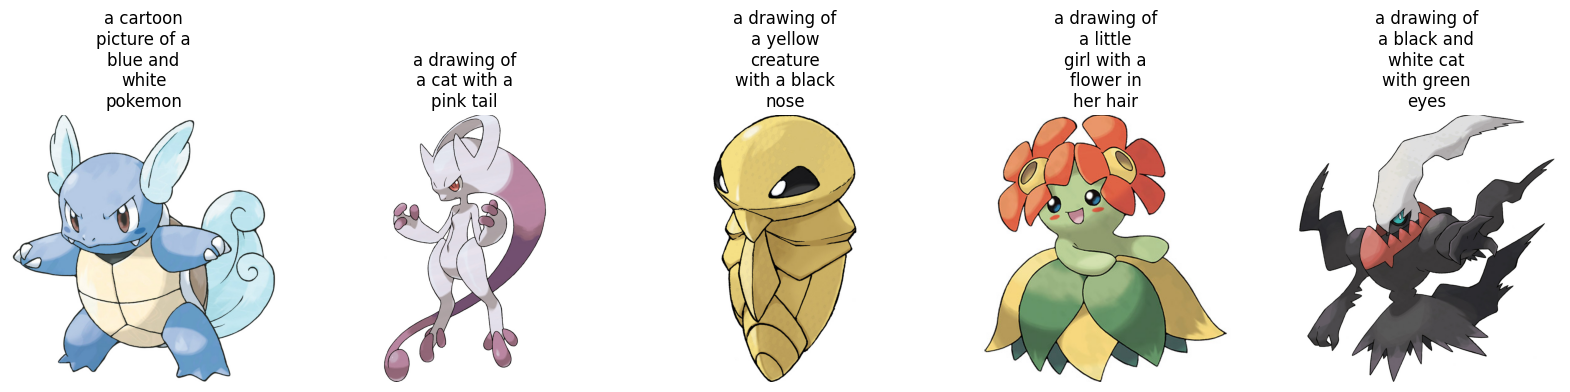

In [7]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)



```
# AutoProcessor as it is multimodel preprocessing
```



In [8]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

In [9]:
train_ds.features.keys()

dict_keys(['image', 'text'])



```
# inputs = processor(images=images, text=captions, padding="max_length")
# learn about this , what it returns and how to go through with this for training loop
```



In [10]:
# inputs = processor(images=train_ds['image'][0], text=train_ds['text'][0], padding="max_length")

In [11]:
# print(input.keys())

In [12]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]   # images
    captions = [x for x in example_batch["text"]]   # labels
    inputs = processor(images=images, text=captions, padding="max_length")    # CRUCIAL POINT TO WORK ON
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [13]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)



```
# wer image captioning dataset ,
# here for evaluation
```





```
# batch_decoding the predicted captions
```



In [14]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}


In [15]:
print(train_ds)

Dataset({
    features: ['image', 'text'],
    num_rows: 749
})


In [16]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [17]:
train_data_loader=DataLoader(train_ds,batch_size=16,shuffle=True)
test_data_loader=DataLoader(test_ds,batch_size=16,shuffle=True)

In [18]:
print(train_data_loader)

# having image and captions

In [19]:
def train(model, train_dataloader, optimizer, scheduler, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, captions in tqdm(train_data_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            # Move images and captions to device
            images = images.to(device)
            captions = captions.to(device)

            # Forward pass
            outputs = model(input_images=images, labels=captions)
            loss = outputs.loss

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Optional: gradient clipping
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        print(f"Average training loss: {average_loss:.4f}")


# So precedures is kind of same for every common tasks